In [30]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [31]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# ADD features (year, month, week of year, week of month)
# Split the date into different components
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekofmonth'] = df['date'].apply(lambda d: (d.day - 1) // 7 + 1)
df['weekday'] = df['date'].dt.weekday
df['hijri'] = df['date'].apply(lambda d: convert.Gregorian(d.year, d.month, d.day).to_hijri())
df['hijri_month'] = df['hijri'].apply(lambda h: h.month)
df['hijri_day'] = df['hijri'].apply(lambda h: h.day)

# Drop the original date column
df.asfreq('d')
df = df.drop('date', axis=1)
df = df.drop('hijri', axis =1 )

df

,y,org,kode_org,des,kode_des,day,month,year,weekofmonth,weekday,hijri_month,hijri_day
0,1014634.0,AGATS,948,BAU-BAU,921,18,1,2023,3,2,6,25
1,62486.0,AGATS,948,KUPANG,681,13,1,2023,2,4,6,20
2,1232000.0,AGATS,948,MAKASSAR,893,16,2,2022,3,2,7,15
3,344312.0,AGATS,948,MERAUKE,979,11,2,2023,2,5,7,20
4,344312.0,AGATS,948,MERAUKE,979,18,1,2023,3,2,6,25
...,...,...,...,...,...,...,...,...,...,...,...,...
21225,2324074.0,WASIOR,981,TANJUNG PRIOK,431,24,9,2022,4,5,2,28
21226,3600595.0,WASIOR,981,TANJUNG PRIOK,431,26,3,2023,4,6,9,4
21227,2324073.0,WASIOR,981,TANJUNG PRIOK,431,26,2,2023,4,6,8,6
21228,2325000.0,WASIOR,981,TANJUNG PRIOK,431,1,1,2022,1,5,5,28


In [32]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['year','month','day','weekofmonth','weekday','hijri_month','hijri_day'])['y'].sum()

data = pd.DataFrame(data)
data
# data = data.asfreq('d')
# data = data.interpolate(method='linear')
# data = data.fillna(0)
# result = seasonal_decompose(data['y'], model = 'additive')
# result.plot()

y
year month day weekofmonth weekday hijri_month hijri_day             
2020 11    18  3           2       4           3           21891600.0
           25  4           2       4           10          27364500.0
           27  4           4       4           12          16123000.0
           28  4           5       4           13           7344400.0
           29  5           6       4           14          31336000.0
...                                                               ...
2023 3     27  4           0       9           5          160134712.0
           28  4           1       9           6             895757.0
           29  5           2       9           7           58286000.0
     4     1   1           5       9           10          31036000.0
           9   2           6       9           18           1510000.0

[629 rows x 1 columns]

In [33]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using the IQR method
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data

y
year month day weekofmonth weekday hijri_month hijri_day             
2020 11    18  3           2       4           3           21891600.0
           25  4           2       4           10          27364500.0
           27  4           4       4           12          16123000.0
           28  4           5       4           13           7344400.0
           29  5           6       4           14          31336000.0
...                                                               ...
2023 3     27  4           0       9           5          160134712.0
           28  4           1       9           6             895757.0
           29  5           2       9           7           58286000.0
     4     1   1           5       9           10          31036000.0
           9   2           6       9           18           1510000.0

[597 rows x 1 columns]

In [34]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [35]:
len(data)

597

In [36]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [37]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [38]:
scaled_train[:10]

array([[0.12502988],
       [0.15629877],
       [0.09207154],
       [0.04191585],
       [0.17898956],
       [0.0522434 ],
       [0.09376099],
       [0.04122796],
       [0.14723446],
       [0.14618319]])

In [39]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [43]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
557/557 [==============================] - 4s 4ms/step - loss: 0.0579
Epoch 2/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0563
Epoch 3/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0557
Epoch 4/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0549
Epoch 5/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0559
Epoch 6/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0554
Epoch 7/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0555
Epoch 8/50
557/557 [==============================] - 3s 5ms/step - loss: 0.0552
Epoch 9/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0553
Epoch 10/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0548
Epoch 11/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0550
Epoch 12/50
557/557 [==============================] - 2s 4ms/step - loss: 0.0544
Epoch 13/50
557/557 [====

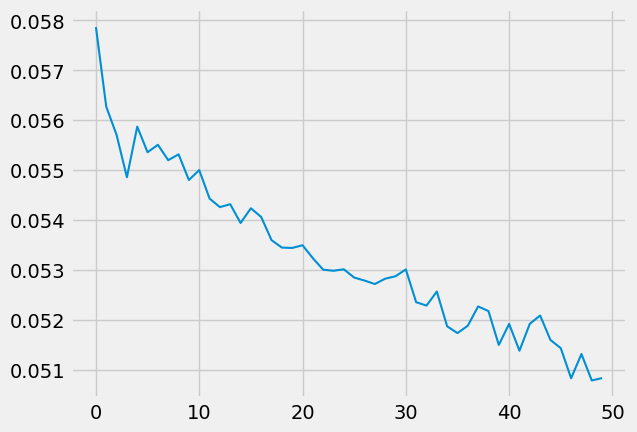

In [44]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [45]:
last_train_batch = scaled_train[-12:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 0s 176ms/step


array([[0.30935085]], dtype=float32)

In [46]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [47]:
test_predictions

[array([0.30935085], dtype=float32),
 array([0.3768245], dtype=float32),
 array([0.2924793], dtype=float32),
 array([0.263965], dtype=float32),
 array([0.23171581], dtype=float32),
 array([0.1741796], dtype=float32),
 array([0.21870223], dtype=float32),
 array([0.19482511], dtype=float32),
 array([0.26293263], dtype=float32),
 array([0.23034345], dtype=float32),
 array([0.2996954], dtype=float32),
 array([0.3048263], dtype=float32),
 array([0.3111152], dtype=float32),
 array([0.29294077], dtype=float32),
 array([0.2677928], dtype=float32),
 array([0.24485621], dtype=float32),
 array([0.22534785], dtype=float32),
 array([0.21837915], dtype=float32),
 array([0.23684944], dtype=float32),
 array([0.24379322], dtype=float32),
 array([0.26212057], dtype=float32),
 array([0.27250087], dtype=float32),
 array([0.28742957], dtype=float32),
 array([0.28744674], dtype=float32),
 array([0.27917665], dtype=float32),
 array([0.26397896], dtype=float32),
 array([0.24991794], dtype=float32),
 array([0.

In [48]:
test.head()

y
year month day weekofmonth weekday hijri_month hijri_day            
2023 2     21  3           1       8           1           2038000.0
           22  4           2       8           2          35886000.0
           25  4           5       8           5          32500000.0
           26  4           6       8           6          12619765.0
     3     1   1           2       8           9          77753000.0

In [49]:
true_predictions = scaler.inverse_transform(test_predictions)

In [50]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_8380\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


y   
year month day weekofmonth weekday hijri_month hijri_day               
2023 2     21  3           1       8           1           2038000.0  \
           22  4           2       8           2          35886000.0   
           25  4           5       8           5          32500000.0   
           26  4           6       8           6          12619765.0   
     3     1   1           2       8           9          77753000.0   

                                                           Predictions  
year month day weekofmonth weekday hijri_month hijri_day                
2023 2     21  3           1       8           1          5.415275e+07  
           22  4           2       8           2          6.596246e+07  
           25  4           5       8           5          5.119977e+07  
           26  4           6       8           6          4.620900e+07  
     3     1   1           2       8           9          4.056452e+07

<Axes: xlabel='year,month,day,weekofmonth,weekday,hijri_month,hijri_day'>

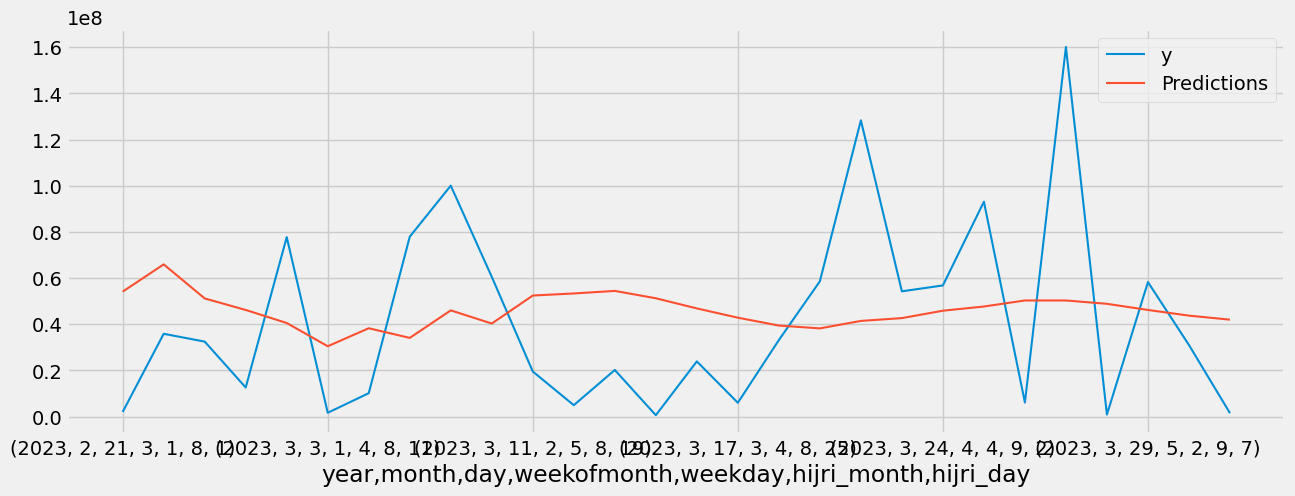

In [51]:
test.plot(figsize=(14,5))

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 42674896.41103644
Mean Value of Test Dataset: 41743598.321428575
